In [1]:
# スコアのばらつきとか

In [2]:
import re
import sys
from time import time, sleep
from pprint import pprint
from functools import partial
from multiprocessing import Pool

import numpy as np
import pandas as pd
import optuna
import matplotlib.pyplot as plt

FILENAME = "main.cpp"

In [3]:
!cp ../answer/{FILENAME} ./{FILENAME}

In [7]:
!g++ {FILENAME} -std=gnu++17 -Wall -Wextra -O2 -DONLINE_JUDGE -o {FILENAME}.out
#!g++ {FILENAME} -std=gnu++17 -Wall -Wextra -O2 -o {FILENAME}.out

main.cpp:49: warning: ignoring #pragma clang attribute [-Wunknown-pragmas]
   49 | #pragma clang attribute push (__attribute__((target("arch=skylake"))),apply_to=function)
      | 
main.cpp:1823: warning: ignoring #pragma clang attribute [-Wunknown-pragmas]
 1823 | #pragma clang attribute pop
      | 
main.cpp: In function ‘void test::TestBitBoardGetSpeed()’:
main.cpp:854:9: warning: unused variable ‘t0’ [-Wunused-variable]
  854 |  double t0;
      |         ^~
main.cpp: In function ‘void globals::UpdateValueTable()’:
main.cpp:961:15: warning: unused variable ‘vm’ [-Wunused-variable]
  961 |   const auto& vm = v_modified[idx_RCSEV];
      |               ^~
main.cpp: In member function ‘void State::RecalcFutureScore()’:
main.cpp:1067:14: warning: unused variable ‘old_subscore2’ [-Wunused-variable]
 1067 |   const auto old_subscore2 = subscore2;
      |              ^~~~~~~~~~~~~
main.cpp: In function ‘void Solve()’:
main.cpp:1630:54: warning: suggest parentheses around ‘-’ in operand 

In [5]:
# テストケース生成
SEED = 0
N_TESTCASES = 100

!mkdir in
for i in range(N_TESTCASES):
    filename = f"{i:04d}.txt"
    seed = SEED + i
    !python3 ../A/tester/generator.py {seed} > ./in/{filename}
!ls in

0000.txt  0013.txt  0026.txt  0039.txt	0052.txt  0065.txt  0078.txt  0091.txt
0001.txt  0014.txt  0027.txt  0040.txt	0053.txt  0066.txt  0079.txt  0092.txt
0002.txt  0015.txt  0028.txt  0041.txt	0054.txt  0067.txt  0080.txt  0093.txt
0003.txt  0016.txt  0029.txt  0042.txt	0055.txt  0068.txt  0081.txt  0094.txt
0004.txt  0017.txt  0030.txt  0043.txt	0056.txt  0069.txt  0082.txt  0095.txt
0005.txt  0018.txt  0031.txt  0044.txt	0057.txt  0070.txt  0083.txt  0096.txt
0006.txt  0019.txt  0032.txt  0045.txt	0058.txt  0071.txt  0084.txt  0097.txt
0007.txt  0020.txt  0033.txt  0046.txt	0059.txt  0072.txt  0085.txt  0098.txt
0008.txt  0021.txt  0034.txt  0047.txt	0060.txt  0073.txt  0086.txt  0099.txt
0009.txt  0022.txt  0035.txt  0048.txt	0061.txt  0074.txt  0087.txt
0010.txt  0023.txt  0036.txt  0049.txt	0062.txt  0075.txt  0088.txt
0011.txt  0024.txt  0037.txt  0050.txt	0063.txt  0076.txt  0089.txt
0012.txt  0025.txt  0038.txt  0051.txt	0064.txt  0077.txt  0090.txt


In [6]:
TESTCASE_DIRECTORY = "./in/"
TESTCASES = [f"{i:04d}.txt" for i in range(N_TESTCASES)]

In [10]:
# 速度チェック
# 並列実行すると半分くらいの速度に

!mkdir out

def parallel(i):
    testcase = TESTCASES[i]
    i = f"{i:04d}"
    t0 = time()
    !./{FILENAME}.out < {TESTCASE_DIRECTORY}{testcase} > ./out/{testcase}
    t = time() - t0
    score = !python3 ../A/tester/judge.py {TESTCASE_DIRECTORY}{testcase} ./out/{testcase}
    print(i, f"time:{t:.4f}", *score)
    score = int(score[0].split(":")[-1])
    return score, t

parallel(0)

mkdir: cannot create directory ‘out’: File exists
elapsed_time=0.0085176  cum_base_sec/elapsed_time=7.24342e+09  modified=6.59169e+09
remaining_time=1.55665
turn=49
time / width = 1.87602e-06
beam_width=131
q.size()=300

elapsed_time=0.0176721  cum_base_sec/elapsed_time=9.14668e+09  modified=8.14479e+09
remaining_time=1.5475
turn=99
time / width = 1.54147e-06
beam_width=190
q.size()=437

elapsed_time=0.0313604  cum_base_sec/elapsed_time=9.69515e+09  modified=8.9337e+09
remaining_time=1.53381
turn=149
time / width = 1.75451e-06
beam_width=237
q.size()=495

elapsed_time=0.049645  cum_base_sec/elapsed_time=9.8423e+09  modified=9.30307e+09
remaining_time=1.51552
turn=199
time / width = 1.96325e-06
beam_width=275
q.size()=505

elapsed_time=0.0726543  cum_base_sec/elapsed_time=9.81495e+09  modified=9.43254e+09
remaining_time=1.49251
turn=249
time / width = 2.25983e-06
beam_width=304
q.size()=512

elapsed_time=0.101854  cum_base_sec/elapsed_time=9.55061e+09  modified=9.28888e+09
remaining_tim

(5430937, 1.8631341457366943)

In [11]:
# もとのスコアの確認

scores = []
times = []

!mkdir out

def parallel(i):
    testcase = TESTCASES[i]
    i = f"{i:04d}"
    t0 = time()
    if i == "0123":
        !./{FILENAME}.out < {TESTCASE_DIRECTORY}{testcase} > ./out/{testcase}
    else:
        !./{FILENAME}.out < {TESTCASE_DIRECTORY}{testcase} > ./out/{testcase} 2> /dev/null
    t = time() - t0
    score = !python3 ../A/tester/judge.py {TESTCASE_DIRECTORY}{testcase} ./out/{testcase}
    print(i, f"time:{t:.4f}", *score)
    score = int(score[0].split(":")[-1])
    return score, t

for i in range(N_TESTCASES):
    score, t = parallel(i)
    scores.append(score)
    times.append(t)

# with Pool(30) as p:
#     for score, t in p.map(parallel, range(N_TESTCASES)):
#         scores.append(score)
#         times.append(t)

np.mean(scores) * 50 / 1e6, np.std(scores) * 50 / 1e6

mkdir: cannot create directory ‘out’: File exists
0000 time:1.8575 score:5309314
0001 time:1.8458 score:5366958
0002 time:1.8491 score:5226458
0003 time:1.8221 score:4884313
0004 time:1.8379 score:5384805
0005 time:1.8388 score:5040819
0006 time:1.8315 score:4790045
0007 time:1.8662 score:5293743
0008 time:1.8447 score:4198502
0009 time:1.8328 score:5290140
0010 time:1.8512 score:5106064
0011 time:1.8449 score:5517703
0012 time:1.7926 score:4420883
0013 time:1.8566 score:5010175
0014 time:1.8546 score:4869735
0015 time:1.8362 score:5021905
0016 time:1.8377 score:5122309
0017 time:1.8673 score:5541383
0018 time:1.8446 score:5412072
0019 time:1.8495 score:5367169
0020 time:1.8393 score:5469054
0021 time:1.8138 score:5165248
0022 time:1.8450 score:4899199
0023 time:1.8167 score:4585513
0024 time:1.8509 score:5153202
0025 time:1.8194 score:4671250
0026 time:1.8488 score:5521019
0027 time:1.8305 score:4887834
0028 time:1.8409 score:5191897
0029 time:1.8470 score:5520705
0030 time:1.8861 sco

(257.037564, 17.837082784356973)

In [13]:
# もとのスコアの確認2

scores2 = []
times2 = []

!mkdir out

def parallel(i):
    testcase = TESTCASES[i]
    i = f"{i:04d}"
    t0 = time()
    if i == "0123":
        !./{FILENAME}.out < {TESTCASE_DIRECTORY}{testcase} > ./out/{testcase}
    else:
        !./{FILENAME}.out < {TESTCASE_DIRECTORY}{testcase} > ./out/{testcase} 2> /dev/null
    t = time() - t0
    score = !python3 ../A/tester/judge.py {TESTCASE_DIRECTORY}{testcase} ./out/{testcase}
    print(i, f"time:{t:.4f}", *score)
    score = int(score[0].split(":")[-1])
    return score, t

for i in range(N_TESTCASES):
    score, t = parallel(i)
    scores2.append(score)
    times2.append(t)

# with Pool(30) as p:
#     for score, t in p.map(parallel, range(N_TESTCASES)):
#         scores.append(score)
#         times.append(t)

np.mean(scores2) * 50 / 1e6, np.std(scores2) * 50 / 1e6

mkdir: cannot create directory ‘out’: File exists
0000 time:1.8574 score:5212304
0001 time:1.8448 score:5314545
0002 time:1.8542 score:5190787
0003 time:1.8249 score:4833519
0004 time:1.8660 score:5406879
0005 time:1.8442 score:4891849
0006 time:1.8297 score:4819015
0007 time:1.8622 score:5310791
0008 time:1.8574 score:4353583
0009 time:1.8229 score:5467323
0010 time:1.8028 score:5056183
0011 time:1.8517 score:5456430
0012 time:1.8413 score:4376880
0013 time:1.8490 score:4878618
0014 time:1.8294 score:4790863
0015 time:1.8585 score:4966740
0016 time:1.8658 score:5343387
0017 time:1.8640 score:5502202
0018 time:1.8412 score:5418953
0019 time:1.8465 score:5489723
0020 time:1.8313 score:5561979
0021 time:1.8337 score:5107387
0022 time:1.8430 score:4952306
0023 time:1.8085 score:4499855
0024 time:1.8084 score:5145033
0025 time:1.8490 score:4644271
0026 time:1.8336 score:5346168
0027 time:1.8542 score:4729255
0028 time:1.8736 score:5275745
0029 time:1.8353 score:5677676
0030 time:1.8263 sco

(256.843214, 18.422352622162673)

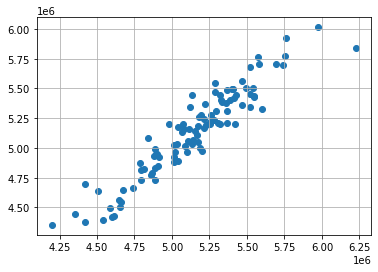

In [15]:
plt.scatter(scores, scores2)
plt.grid()

In [16]:
FILENAME2 = "main2.cpp"
!g++ {FILENAME2} -std=gnu++17 -Wall -Wextra -O2 -DONLINE_JUDGE -o {FILENAME2}.out


main2.cpp:49: warning: ignoring #pragma clang attribute [-Wunknown-pragmas]
   49 | #pragma clang attribute push (__attribute__((target("arch=skylake"))),apply_to=function)
      | 
main2.cpp:1837: warning: ignoring #pragma clang attribute [-Wunknown-pragmas]
 1837 | #pragma clang attribute pop
      | 
main2.cpp: In function ‘void test::TestBitBoardGetSpeed()’:
main2.cpp:860:9: warning: unused variable ‘t0’ [-Wunused-variable]
  860 |  double t0;
      |         ^~
main2.cpp: In function ‘void globals::UpdateValueTable()’:
main2.cpp:967:15: warning: unused variable ‘vm’ [-Wunused-variable]
  967 |   const auto& vm = v_modified[idx_RCSEV];
      |               ^~
main2.cpp: In member function ‘void State::RecalcFutureScore()’:
main2.cpp:1073:14: warning: unused variable ‘old_subscore2’ [-Wunused-variable]
 1073 |   const auto old_subscore2 = subscore2;
      |              ^~~~~~~~~~~~~
main2.cpp: In member function ‘void State::DoSecondHalf(const u8&, const State::FirstHalfResult&, c

In [17]:
# 速度チェック
# 並列実行すると半分くらいの速度に

!mkdir out

def parallel(i):
    testcase = TESTCASES[i]
    i = f"{i:04d}"
    t0 = time()
    !./{FILENAME2}.out < {TESTCASE_DIRECTORY}{testcase} > ./out/{testcase}
    t = time() - t0
    score = !python3 ../A/tester/judge.py {TESTCASE_DIRECTORY}{testcase} ./out/{testcase}
    print(i, f"time:{t:.4f}", *score)
    score = int(score[0].split(":")[-1])
    return score, t

parallel(0)

mkdir: cannot create directory ‘out’: File exists
elapsed_time=0.00992752  cum_base_sec/elapsed_time=5.43167e+09  modified=5.63022e+09
remaining_time=1.55365
turn=49
time / width = 2.52318e-06
beam_width=112
q.size()=341

elapsed_time=0.0185165  cum_base_sec/elapsed_time=7.49306e+09  modified=7.01489e+09
remaining_time=1.54506
turn=99
time / width = 1.53591e-06
beam_width=164
q.size()=458

elapsed_time=0.0319875  cum_base_sec/elapsed_time=8.1866e+09  modified=7.73404e+09
remaining_time=1.53159
turn=149
time / width = 1.70711e-06
beam_width=205
q.size()=507

elapsed_time=0.0499107  cum_base_sec/elapsed_time=8.45992e+09  modified=8.11085e+09
remaining_time=1.51366
turn=199
time / width = 1.87677e-06
beam_width=239
q.size()=511

elapsed_time=0.0736223  cum_base_sec/elapsed_time=8.38316e+09  modified=8.14309e+09
remaining_time=1.48995
turn=249
time / width = 2.1111e-06
beam_width=262
q.size()=512

elapsed_time=0.102351  cum_base_sec/elapsed_time=8.2342e+09  modified=8.0673e+09
remaining_ti

(5187163, 1.9082930088043213)

In [21]:
# もとのスコアの確認3

scores3 = []
times3 = []

!mkdir out

def parallel(i):
    testcase = TESTCASES[i]
    i = f"{i:04d}"
    t0 = time()
    if i == "0123":
        !./{FILENAME2}.out < {TESTCASE_DIRECTORY}{testcase} > ./out/{testcase}
    else:
        !./{FILENAME2}.out < {TESTCASE_DIRECTORY}{testcase} > ./out/{testcase} 2> /dev/null
    t = time() - t0
    score = !python3 ../A/tester/judge.py {TESTCASE_DIRECTORY}{testcase} ./out/{testcase}
    print(i, f"time:{t:.4f}", *score)
    score = int(score[0].split(":")[-1])
    return score, t

for i in range(N_TESTCASES):
    score, t = parallel(i)
    scores3.append(score)
    times3.append(t)

# with Pool(30) as p:
#     for score, t in p.map(parallel, range(N_TESTCASES)):
#         scores.append(score)
#         times.append(t)

np.mean(scores3) * 50 / 1e6, np.std(scores3) * 50 / 1e6

mkdir: cannot create directory ‘out’: File exists
0000 time:1.8832 score:5168544
0001 time:1.8630 score:4927827
0002 time:1.9026 score:4951559
0003 time:1.8517 score:4513015
0004 time:1.8813 score:5129646
0005 time:1.9134 score:4663051
0006 time:1.9090 score:4946886
0007 time:1.9309 score:5047531
0008 time:1.8523 score:3972182
0009 time:1.8899 score:5057149
0010 time:1.8786 score:4570533
0011 time:1.8796 score:5266989
0012 time:1.8851 score:4058698
0013 time:1.8974 score:4853534
0014 time:1.8848 score:4615899
0015 time:1.8858 score:4795964
0016 time:1.8863 score:4880015
0017 time:1.8829 score:5156835
0018 time:1.8899 score:4986040
0019 time:1.8969 score:5098331
0020 time:1.8865 score:5198965
0021 time:1.8923 score:4909872
0022 time:1.8647 score:4821675
0023 time:1.8730 score:4662006
0024 time:1.8951 score:4914758
0025 time:1.8951 score:4549729
0026 time:1.8872 score:5056080
0027 time:1.8958 score:4490156
0028 time:1.8883 score:4964734
0029 time:1.8887 score:5580025
0030 time:1.8795 sco

(244.142166, 16.41350555882393)

In [22]:
np.mean(scores3) * 50 / 1e6, np.std(scores3) * 50 / 1e6

(244.142166, 16.41350555882393)

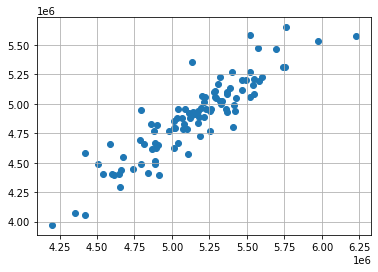

In [23]:
plt.scatter(scores, scores3)
plt.grid()

In [25]:
FILENAME4 = "main4.cpp"
!g++ {FILENAME4} -std=gnu++17 -Wall -Wextra -O2 -DONLINE_JUDGE -o {FILENAME4}.out

main4.cpp:49: warning: ignoring #pragma clang attribute [-Wunknown-pragmas]
   49 | #pragma clang attribute push (__attribute__((target("arch=skylake"))),apply_to=function)
      | 
main4.cpp:1892: warning: ignoring #pragma clang attribute [-Wunknown-pragmas]
 1892 | #pragma clang attribute pop
      | 
main4.cpp: In function ‘void test::TestBitBoardGetSpeed()’:
main4.cpp:854:9: warning: unused variable ‘t0’ [-Wunused-variable]
  854 |  double t0;
      |         ^~
main4.cpp: In function ‘void globals::UpdateValueTable()’:
main4.cpp:961:15: warning: unused variable ‘vm’ [-Wunused-variable]
  961 |   const auto& vm = v_modified[idx_RCSEV];
      |               ^~
main4.cpp: In member function ‘void State::RecalcFutureScore()’:
main4.cpp:1069:14: warning: unused variable ‘old_subscore2’ [-Wunused-variable]
 1069 |   const auto old_subscore2 = subscore2;
      |              ^~~~~~~~~~~~~
main4.cpp: In member function ‘void State::GetNextStates(Vector&) const’:
main4.cpp:1392:47: warnin

main4.cpp:1687:8: warning: ignoring return value of ‘int scanf(const char*, ...)’, declared with attribute warn_unused_result [-Wunused-result]
 1687 |   scanf("%d %d %d", &buf, &buf, &buf);
      |   ~~~~~^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
main4.cpp:1689:9: warning: ignoring return value of ‘int scanf(const char*, ...)’, declared with attribute warn_unused_result [-Wunused-result]
 1689 |    scanf("%hhd %hhd %hd %hd %hd", &R[i], &C[i], &S[i], &E[i], &V[i]);
      |    ~~~~~^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [26]:
# 速度チェック
# 並列実行すると半分くらいの速度に

!mkdir out

def parallel(i):
    testcase = TESTCASES[i]
    i = f"{i:04d}"
    t0 = time()
    !./{FILENAME4}.out < {TESTCASE_DIRECTORY}{testcase} > ./out/{testcase}
    t = time() - t0
    score = !python3 ../A/tester/judge.py {TESTCASE_DIRECTORY}{testcase} ./out/{testcase}
    print(i, f"time:{t:.4f}", *score)
    score = int(score[0].split(":")[-1])
    return score, t

parallel(0)

mkdir: cannot create directory ‘out’: File exists
elapsed_time=0.00926781  cum_base_sec/elapsed_time=6.15806e+09  modified=6.03199e+09
remaining_time=1.55228
turn=49
time / width = 2.46605e-06
beam_width=120
q.size()=282

elapsed_time=0.0177621  cum_base_sec/elapsed_time=8.34735e+09  modified=7.59467e+09
remaining_time=1.54379
turn=99
time / width = 1.53208e-06
beam_width=177
q.size()=437

elapsed_time=0.0310449  cum_base_sec/elapsed_time=9.08199e+09  modified=8.439e+09
remaining_time=1.5305
turn=149
time / width = 1.61846e-06
beam_width=224
q.size()=499

elapsed_time=0.0492052  cum_base_sec/elapsed_time=9.27434e+09  modified=8.80982e+09
remaining_time=1.51234
turn=199
time / width = 1.70921e-06
beam_width=260
q.size()=502

elapsed_time=0.0720464  cum_base_sec/elapsed_time=9.28575e+09  modified=8.95298e+09
remaining_time=1.4895
turn=249
time / width = 1.82186e-06
beam_width=288
q.size()=509

elapsed_time=0.0985341  cum_base_sec/elapsed_time=9.34145e+09  modified=9.08748e+09
remaining_t

(5286654, 1.8620359897613525)

In [27]:
# もとのスコアの確認3

scores4 = []
times4 = []

!mkdir out

def parallel(i):
    testcase = TESTCASES[i]
    i = f"{i:04d}"
    t0 = time()
    if i == "0123":
        !./{FILENAME4}.out < {TESTCASE_DIRECTORY}{testcase} > ./out/{testcase}
    else:
        !./{FILENAME4}.out < {TESTCASE_DIRECTORY}{testcase} > ./out/{testcase} 2> /dev/null
    t = time() - t0
    score = !python3 ../A/tester/judge.py {TESTCASE_DIRECTORY}{testcase} ./out/{testcase}
    print(i, f"time:{t:.4f}", *score)
    score = int(score[0].split(":")[-1])
    return score, t

for i in range(N_TESTCASES):
    score, t = parallel(i)
    scores4.append(score)
    times4.append(t)

# with Pool(30) as p:
#     for score, t in p.map(parallel, range(N_TESTCASES)):
#         scores.append(score)
#         times.append(t)

np.mean(scores4) * 50 / 1e6, np.std(scores4) * 50 / 1e6

mkdir: cannot create directory ‘out’: File exists
0000 time:1.8692 score:5264702
0001 time:1.8763 score:5157420
0002 time:1.8702 score:5319952
0003 time:1.8654 score:4675681
0004 time:1.8633 score:5359567
0005 time:1.8402 score:4861154
0006 time:1.8305 score:4744794
0007 time:1.8510 score:5089727
0008 time:1.8757 score:3961170
0009 time:1.7998 score:5258732
0010 time:1.8348 score:4981414
0011 time:1.9267 score:5576689
0012 time:1.8700 score:4256905
0013 time:1.8271 score:5120141
0014 time:1.8225 score:4845966
0015 time:1.8346 score:4868200
0016 time:1.8534 score:5171866
0017 time:1.8978 score:5530081
0018 time:1.8506 score:5246037
0019 time:1.8879 score:5237007
0020 time:1.8740 score:5411879
0021 time:1.8451 score:5147747
0022 time:1.9035 score:4977838
0023 time:1.8220 score:4684351
0024 time:1.8654 score:5048969
0025 time:1.8295 score:4726408
0026 time:1.8611 score:5546959
0027 time:1.8147 score:4695996
0028 time:1.8705 score:5212132
0029 time:1.8233 score:5506722
0030 time:1.8601 sco

(254.81978849999996, 18.581077363024264)

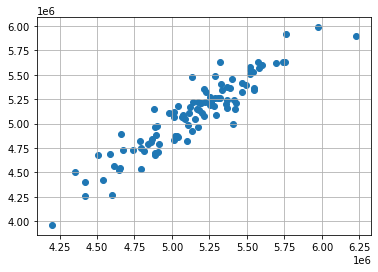

In [28]:
plt.scatter(scores, scores4)
plt.grid()

In [33]:
np.array([max(s1, s2) for s1, s2 in zip(scores, scores2)]).mean() * 50

259447770.5

In [34]:
FILENAME5 = "main5.cpp"
!g++ {FILENAME5} -std=gnu++17 -Wall -Wextra -O2 -DONLINE_JUDGE -o {FILENAME5}.out

main5.cpp:49: warning: ignoring #pragma clang attribute [-Wunknown-pragmas]
   49 | #pragma clang attribute push (__attribute__((target("arch=skylake"))),apply_to=function)
      | 
main5.cpp:1895: warning: ignoring #pragma clang attribute [-Wunknown-pragmas]
 1895 | #pragma clang attribute pop
      | 
main5.cpp: In function ‘void test::TestBitBoardGetSpeed()’:
main5.cpp:854:9: warning: unused variable ‘t0’ [-Wunused-variable]
  854 |  double t0;
      |         ^~
main5.cpp: In function ‘void globals::UpdateValueTable()’:
main5.cpp:961:15: warning: unused variable ‘vm’ [-Wunused-variable]
  961 |   const auto& vm = v_modified[idx_RCSEV];
      |               ^~
main5.cpp: In member function ‘void State::RecalcFutureScore()’:
main5.cpp:1068:14: warning: unused variable ‘old_subscore2’ [-Wunused-variable]
 1068 |   const auto old_subscore2 = subscore2;
      |              ^~~~~~~~~~~~~
main5.cpp: In function ‘void Solve()’:
main5.cpp:1702:54: warning: suggest parentheses around ‘-’ i

In [35]:
# 速度チェック
# 並列実行すると半分くらいの速度に

!mkdir out

def parallel(i):
    testcase = TESTCASES[i]
    i = f"{i:04d}"
    t0 = time()
    !./{FILENAME5}.out < {TESTCASE_DIRECTORY}{testcase} > ./out/{testcase}
    t = time() - t0
    score = !python3 ../A/tester/judge.py {TESTCASE_DIRECTORY}{testcase} ./out/{testcase}
    print(i, f"time:{t:.4f}", *score)
    score = int(score[0].split(":")[-1])
    return score, t

parallel(0)

mkdir: cannot create directory ‘out’: File exists
elapsed_time=0.00958342  cum_base_sec/elapsed_time=5.75529e+09  modified=5.81233e+09
remaining_time=1.55157
turn=49
time / width = 2.17999e-06
beam_width=115
q.size()=288

elapsed_time=0.0177488  cum_base_sec/elapsed_time=8.09458e+09  modified=7.41884e+09
remaining_time=1.5434
turn=99
time / width = 1.3445e-06
beam_width=173
q.size()=385

elapsed_time=0.0309054  cum_base_sec/elapsed_time=8.89319e+09  modified=8.28608e+09
remaining_time=1.53025
turn=149
time / width = 1.6789e-06
beam_width=220
q.size()=498

elapsed_time=0.0484491  cum_base_sec/elapsed_time=9.2218e+09  modified=8.75843e+09
remaining_time=1.5127
turn=199
time / width = 1.73947e-06
beam_width=258
q.size()=509

elapsed_time=0.0714861  cum_base_sec/elapsed_time=9.21514e+09  modified=8.88705e+09
remaining_time=1.48967
turn=249
time / width = 2.01494e-06
beam_width=286
q.size()=510

elapsed_time=0.101314  cum_base_sec/elapsed_time=8.90737e+09  modified=8.69098e+09
remaining_tim

(5303334, 1.8449010848999023)

In [36]:
# もとのスコアの確認3

scores5 = []
times5 = []

!mkdir out

def parallel(i):
    testcase = TESTCASES[i]
    i = f"{i:04d}"
    t0 = time()
    if i == "0123":
        !./{FILENAME5}.out < {TESTCASE_DIRECTORY}{testcase} > ./out/{testcase}
    else:
        !./{FILENAME5}.out < {TESTCASE_DIRECTORY}{testcase} > ./out/{testcase} 2> /dev/null
    t = time() - t0
    score = !python3 ../A/tester/judge.py {TESTCASE_DIRECTORY}{testcase} ./out/{testcase}
    print(i, f"time:{t:.4f}", *score)
    score = int(score[0].split(":")[-1])
    return score, t

for i in range(N_TESTCASES):
    score, t = parallel(i)
    scores5.append(score)
    times5.append(t)

# with Pool(30) as p:
#     for score, t in p.map(parallel, range(N_TESTCASES)):
#         scores.append(score)
#         times.append(t)

np.mean(scores5) * 50 / 1e6, np.std(scores5) * 50 / 1e6

mkdir: cannot create directory ‘out’: File exists
0000 time:1.8446 score:5185969
0001 time:1.8334 score:4974963
0002 time:1.8447 score:5205555
0003 time:1.8649 score:4690472
0004 time:1.8397 score:5279603
0005 time:1.8405 score:4887043
0006 time:1.8612 score:4780234
0007 time:1.8533 score:5100519
0008 time:1.8078 score:4173762
0009 time:1.8240 score:5307987
0010 time:1.8297 score:5076424
0011 time:1.8016 score:5432646
0012 time:1.8313 score:4412177
0013 time:1.8394 score:4840696
0014 time:1.8364 score:4767343
0015 time:1.8279 score:4885148
0016 time:1.8330 score:5158716
0017 time:1.8818 score:5476120
0018 time:1.8514 score:5103564
0019 time:1.8528 score:5333913
0020 time:1.8475 score:5387758
0021 time:1.8435 score:5098766
0022 time:1.8461 score:4869067
0023 time:1.7993 score:4807206
0024 time:1.8275 score:5133773
0025 time:1.8260 score:4535466
0026 time:1.8343 score:5623682
0027 time:1.8552 score:4640803
0028 time:1.8445 score:5118304
0029 time:1.8548 score:5516040
0030 time:1.8352 sco

(254.1733415, 17.787440791846727)

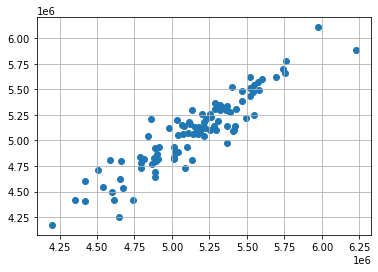

In [37]:
plt.scatter(scores, scores5)
plt.grid()

In [38]:
FILENAME6 = "main6.cpp"
!g++ {FILENAME6} -std=gnu++17 -Wall -Wextra -O2 -DONLINE_JUDGE -o {FILENAME6}.out

main6.cpp:49: warning: ignoring #pragma clang attribute [-Wunknown-pragmas]
   49 | #pragma clang attribute push (__attribute__((target("arch=skylake"))),apply_to=function)
      | 
main6.cpp:1845: warning: ignoring #pragma clang attribute [-Wunknown-pragmas]
 1845 | #pragma clang attribute pop
      | 
main6.cpp: In function ‘void test::TestBitBoardGetSpeed()’:
main6.cpp:854:9: warning: unused variable ‘t0’ [-Wunused-variable]
  854 |  double t0;
      |         ^~
main6.cpp: In function ‘void globals::UpdateValueTable()’:
main6.cpp:961:15: warning: unused variable ‘vm’ [-Wunused-variable]
  961 |   const auto& vm = v_modified[idx_RCSEV];
      |               ^~
main6.cpp: In member function ‘void State::RecalcFutureScore()’:
main6.cpp:1067:14: warning: unused variable ‘old_subscore2’ [-Wunused-variable]
 1067 |   const auto old_subscore2 = subscore2;
      |              ^~~~~~~~~~~~~
main6.cpp: In function ‘void Solve()’:
main6.cpp:1652:54: warning: suggest parentheses around ‘-’ i

In [39]:
# 速度チェック
# 並列実行すると半分くらいの速度に

!mkdir out

def parallel(i):
    testcase = TESTCASES[i]
    i = f"{i:04d}"
    t0 = time()
    !./{FILENAME6}.out < {TESTCASE_DIRECTORY}{testcase} > ./out/{testcase}
    t = time() - t0
    score = !python3 ../A/tester/judge.py {TESTCASE_DIRECTORY}{testcase} ./out/{testcase}
    print(i, f"time:{t:.4f}", *score)
    score = int(score[0].split(":")[-1])
    return score, t

parallel(0)

mkdir: cannot create directory ‘out’: File exists
elapsed_time=0.00886846  cum_base_sec/elapsed_time=6.83245e+09  modified=6.38741e+09
remaining_time=1.55403
turn=49
time / width = 2.32084e-06
beam_width=127
q.size()=295

elapsed_time=0.0179348  cum_base_sec/elapsed_time=8.70707e+09  modified=7.84981e+09
remaining_time=1.54496
turn=99
time / width = 1.344e-06
beam_width=183
q.size()=439

elapsed_time=0.0317063  cum_base_sec/elapsed_time=9.24653e+09  modified=8.58132e+09
remaining_time=1.53119
turn=149
time / width = 1.55204e-06
beam_width=228
q.size()=497

elapsed_time=0.0500147  cum_base_sec/elapsed_time=9.40652e+09  modified=8.9303e+09
remaining_time=1.51288
turn=199
time / width = 1.71317e-06
beam_width=263
q.size()=504

elapsed_time=0.0726395  cum_base_sec/elapsed_time=9.45281e+09  modified=9.10601e+09
remaining_time=1.49026
turn=249
time / width = 2.03219e-06
beam_width=293
q.size()=512

elapsed_time=0.101109  cum_base_sec/elapsed_time=9.27703e+09  modified=9.03348e+09
remaining_t

(5260445, 1.8386023044586182)

In [40]:
# もとのスコアの確認3

scores6 = []
times6 = []

!mkdir out

def parallel(i):
    testcase = TESTCASES[i]
    i = f"{i:04d}"
    t0 = time()
    if i == "0123":
        !./{FILENAME6}.out < {TESTCASE_DIRECTORY}{testcase} > ./out/{testcase}
    else:
        !./{FILENAME6}.out < {TESTCASE_DIRECTORY}{testcase} > ./out/{testcase} 2> /dev/null
    t = time() - t0
    score = !python3 ../A/tester/judge.py {TESTCASE_DIRECTORY}{testcase} ./out/{testcase}
    print(i, f"time:{t:.4f}", *score)
    score = int(score[0].split(":")[-1])
    return score, t

for i in range(N_TESTCASES):
    score, t = parallel(i)
    scores6.append(score)
    times6.append(t)

# with Pool(30) as p:
#     for score, t in p.map(parallel, range(N_TESTCASES)):
#         scores.append(score)
#         times.append(t)

np.mean(scores6) * 50 / 1e6, np.std(scores6) * 50 / 1e6

mkdir: cannot create directory ‘out’: File exists
0000 time:1.8403 score:5249507
0001 time:1.8485 score:5331427
0002 time:1.8587 score:5253049
0003 time:1.8207 score:4881151
0004 time:1.8425 score:5383572
0005 time:1.8379 score:5041078
0006 time:1.8340 score:4781284
0007 time:1.8607 score:5252796
0008 time:1.8408 score:4179455
0009 time:1.8433 score:5318079
0010 time:1.8041 score:5031237
0011 time:1.8191 score:5646286
0012 time:1.8036 score:4503212
0013 time:1.8194 score:5232131
0014 time:1.8634 score:4826763
0015 time:1.8438 score:4912344
0016 time:1.8393 score:5190853
0017 time:1.8645 score:5622450
0018 time:1.8228 score:5454989
0019 time:1.8390 score:5385468
0020 time:1.8480 score:5602234
0021 time:1.8354 score:5213895
0022 time:1.8404 score:4923728
0023 time:1.8230 score:4537668
0024 time:1.8452 score:5227073
0025 time:1.8363 score:4628088
0026 time:1.8018 score:5515097
0027 time:1.8565 score:4807888
0028 time:1.8433 score:5120515
0029 time:1.8634 score:5618956
0030 time:1.8233 sco

(258.05807799999997, 18.199575139007116)

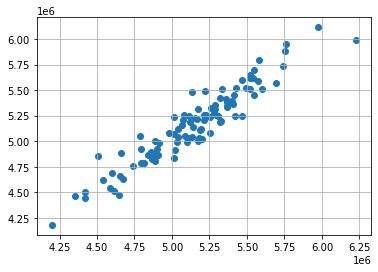

In [41]:
plt.scatter(scores, scores6)
plt.grid()

In [42]:
FILENAME7 = "main7.cpp"
!g++ {FILENAME7} -std=gnu++17 -Wall -Wextra -O2 -DONLINE_JUDGE -o {FILENAME7}.out

main7.cpp:49: warning: ignoring #pragma clang attribute [-Wunknown-pragmas]
   49 | #pragma clang attribute push (__attribute__((target("arch=skylake"))),apply_to=function)
      | 
main7.cpp:1869: warning: ignoring #pragma clang attribute [-Wunknown-pragmas]
 1869 | #pragma clang attribute pop
      | 
main7.cpp: In function ‘void test::TestBitBoardGetSpeed()’:
main7.cpp:854:9: warning: unused variable ‘t0’ [-Wunused-variable]
  854 |  double t0;
      |         ^~
main7.cpp: In function ‘void globals::UpdateValueTable()’:
main7.cpp:961:15: warning: unused variable ‘vm’ [-Wunused-variable]
  961 |   const auto& vm = v_modified[idx_RCSEV];
      |               ^~
main7.cpp: In member function ‘void State::RecalcFutureScore()’:
main7.cpp:1067:14: warning: unused variable ‘old_subscore2’ [-Wunused-variable]
 1067 |   const auto old_subscore2 = subscore2;
      |              ^~~~~~~~~~~~~
main7.cpp: In function ‘void Solve()’:
main7.cpp:1676:54: warning: suggest parentheses around ‘-’ i

In [43]:
# 速度チェック
# 並列実行すると半分くらいの速度に

!mkdir out

def parallel(i):
    testcase = TESTCASES[i]
    i = f"{i:04d}"
    t0 = time()
    !./{FILENAME7}.out < {TESTCASE_DIRECTORY}{testcase} > ./out/{testcase}
    t = time() - t0
    score = !python3 ../A/tester/judge.py {TESTCASE_DIRECTORY}{testcase} ./out/{testcase}
    print(i, f"time:{t:.4f}", *score)
    score = int(score[0].split(":")[-1])
    return score, t

parallel(0)

mkdir: cannot create directory ‘out’: File exists
elapsed_time=0.00924552  cum_base_sec/elapsed_time=6.42549e+09  modified=6.17681e+09
remaining_time=1.55232
turn=49
time / width = 2.42849e-06
beam_width=123
q.size()=291

elapsed_time=0.0186661  cum_base_sec/elapsed_time=8.06221e+09  modified=7.41932e+09
remaining_time=1.5429
turn=99
time / width = 1.4393e-06
beam_width=173
q.size()=424

elapsed_time=0.0327831  cum_base_sec/elapsed_time=8.49818e+09  modified=7.99502e+09
remaining_time=1.52878
turn=149
time / width = 1.65151e-06
beam_width=212
q.size()=485

elapsed_time=0.0513431  cum_base_sec/elapsed_time=8.623e+09  modified=8.26124e+09
remaining_time=1.51022
turn=199
time / width = 1.93388e-06
beam_width=243
q.size()=499

elapsed_time=0.0741212  cum_base_sec/elapsed_time=8.65866e+09  modified=8.39408e+09
remaining_time=1.48745
turn=249
time / width = 2.18237e-06
beam_width=270
q.size()=511

elapsed_time=0.102632  cum_base_sec/elapsed_time=8.50701e+09  modified=8.32145e+09
remaining_ti

(5211927, 1.8442556858062744)

In [44]:
# もとのスコアの確認3

scores7 = []
times7 = []

!mkdir out

def parallel(i):
    testcase = TESTCASES[i]
    i = f"{i:04d}"
    t0 = time()
    if i == "0123":
        !./{FILENAME7}.out < {TESTCASE_DIRECTORY}{testcase} > ./out/{testcase}
    else:
        !./{FILENAME7}.out < {TESTCASE_DIRECTORY}{testcase} > ./out/{testcase} 2> /dev/null
    t = time() - t0
    score = !python3 ../A/tester/judge.py {TESTCASE_DIRECTORY}{testcase} ./out/{testcase}
    print(i, f"time:{t:.4f}", *score)
    score = int(score[0].split(":")[-1])
    return score, t

for i in range(N_TESTCASES):
    score, t = parallel(i)
    scores7.append(score)
    times7.append(t)

# with Pool(30) as p:
#     for score, t in p.map(parallel, range(N_TESTCASES)):
#         scores.append(score)
#         times.append(t)

np.mean(scores7) * 50 / 1e6, np.std(scores7) * 50 / 1e6

mkdir: cannot create directory ‘out’: File exists
0000 time:1.8167 score:5261876
0001 time:1.8438 score:5297742
0002 time:1.8588 score:5231846
0003 time:1.8450 score:4705031
0004 time:1.8268 score:5338833
0005 time:1.8345 score:4923774
0006 time:1.8282 score:4816973
0007 time:1.8170 score:5127666
0008 time:1.7994 score:4396272
0009 time:1.8303 score:5219666
0010 time:1.8289 score:5145448
0011 time:1.8269 score:5556976
0012 time:1.8130 score:4560847
0013 time:1.8443 score:5036217
0014 time:1.8165 score:4940133
0015 time:1.8346 score:5013306
0016 time:1.8409 score:5158107
0017 time:1.8485 score:5597977
0018 time:1.8286 score:5405440
0019 time:1.8460 score:5385758
0020 time:1.8556 score:5451763
0021 time:1.8217 score:5199923
0022 time:1.8314 score:4976973
0023 time:1.8244 score:4650803
0024 time:1.8449 score:5105897
0025 time:1.8412 score:4774687
0026 time:1.8095 score:5334515
0027 time:1.8483 score:5045124
0028 time:1.8420 score:5119144
0029 time:1.8565 score:5512612
0030 time:1.8301 sco

(256.788931, 17.35285825498033)

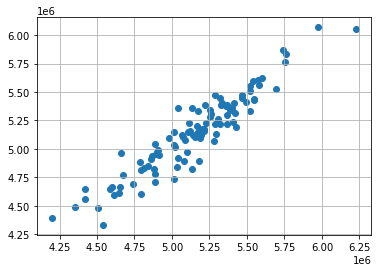

In [45]:
plt.scatter(scores, scores7)
plt.grid()